<a href="https://colab.research.google.com/github/IshanBhattOfficial/Carvana_Image_Masking_Challenge_kernel/blob/master/CarvanaUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
####YOU NEED TO HAVE YOUR KAGGLE API KEY WITH YOU TO RUN THIS SCRIPT
###UPLOAD "kaggle.json" in "/content/."


#install dependency
!pip install kaggle
print("kaggle installed")
##mount drive and upload kaggle.json
from google.colab import drive
drive.mount('/gdrive')

!cp /gdrive/kaggle.json /content

##File system config
!mkdir -p ~/.kaggle
!rm -rf sample-data
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!rm -rf /content/sample_data
!mkdir input

print("filessytm cleaned")

##Downloading CARVANA through kaggle api 
!kaggle competitions download -c carvana-image-masking-challenge > /dev/null
print("dataset loaded\n extracting..")

##Unzip dataset
!unzip -qq metadata.csv.zip -d input && rm metadata.csv.zip
print("1/7")


!unzip -qq sample_submission.csv.zip -d input && rm sample_submission.csv.zip
print("2/7")
!unzip -qq test.zip -d input && rm test.zip
print("3/7")

!rm test_hq.zip
print("4/7")


!unzip -qq train.zip -d input && rm train.zip
print("5/7")
!rm train_hq.zip
print("6/7")
!unzip -qq train_masks.zip -d input && rm train_masks.zip
print("7/7")
!unzip -qq train_masks.csv.zip -d input && rm train_masks.csv.zip



kaggle installed
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
cp: cannot stat '/gdrive/kaggle.json': No such file or directory
filessytm cleaned
100% 81.2k/81.2k [00:00<00:00, 69.5MB/s]
100% 29.1M/29.1M [00:00<00:00, 57.9MB/s]
100% 15.3M/15.3M [00:00<00:00, 16.1MB/s]
100% 202k/202k [00:00<00:00, 91.9MB/s]
100% 405M/405M [00:08<00:00, 47.8MB/s]
100% 7.76G/7.76G [02:43<00:00, 50.9MB/s]
100% 107k/107k [00:00<00:00, 83.7MB/s]
100% 804M/804M [00:18<00:00, 45.8MB/s]
100% 15.4G/15.4G [06:10<00:00, 44.8MB/s]
dataset lo

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from skimage import io, transform
import cv2
import tensorflow as tf

In [4]:
import os
print(os.listdir("input"))

['sample_submission.csv', 'train_masks.csv', 'test', 'train_masks', 'metadata.csv', 'train']


In [0]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
CHANNEL=3
input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL)
mask_shape=(IMAGE_WIDTH, IMAGE_HEIGHT)
image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size=10
epochs=3

In [0]:
metadata = pd.read_csv("input/metadata.csv")
train_masks = pd.read_csv("input/train_masks.csv")
testdata = pd.read_csv("input/sample_submission.csv")

In [7]:
print(train_masks.shape)
print(testdata.shape)

(5088, 2)
(100064, 2)


In [0]:
train_masks = train_masks.sample(1000).reset_index()
testdata = testdata.sample(batch_size).reset_index()

In [0]:
filenames = train_masks.img.str.split(".")
maskfilenames = filenames.str[0] + "_mask.gif"
train_masks['img_mask'] = maskfilenames
train_masks['angle'] = filenames.str[0].str.split("_").str[1].astype(int)
#train_masks.head()

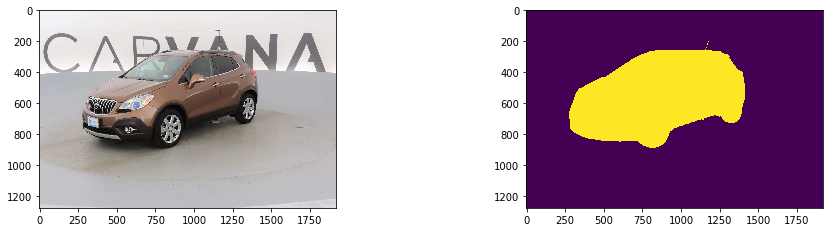

In [10]:
sample = train_masks.sample()
fig=plt.figure(figsize=(16, 8))
for index, s in sample.iterrows():
    original_image = io.imread('input/train/'+s.img)
    masked_image = io.imread('input/train_masks/'+s.img_mask)
    plt.subplot(2, 2, 1)
    plt.imshow(original_image)
    plt.subplot(2, 2, 2)
    plt.imshow(masked_image)

In [0]:
from skimage.transform import AffineTransform, warp
def shift(image, translation_matrix):
    transformer = AffineTransform(translation=translation_matrix)
    return warp(image, transformer, mode='wrap', preserve_range=True)

In [0]:
def tranform_image(original_image, mask_image):
    image = original_image
    mask = mask_image
    
    isHorizontalFlip = np.random.random() < 0.5
    isShift = np.random.random() < 0.5

    if isShift:
        translation_matrix = np.random.random_integers(-10, 10), np.random.random_integers(-10, 10)
        image = shift(image, translation_matrix)
        mask = shift(mask, translation_matrix)

    if isHorizontalFlip:
        image = image[:, ::-1]
        mask = mask[:, ::-1]
    
    return image, mask

In [0]:
def data_gen_small(data_dir, mask_dir, df_data, precess_batch_size, original_image_shape, mask_image_shape):
    while True:
        for k, ix in df_data.groupby(np.arange(len(df_data))//precess_batch_size):
            imgs = []
            labels = []
            for index, row in ix.iterrows():
                # images
                original_img = io.imread(data_dir + row.img)
                resized_img = transform.resize(original_img, image_size, mode='constant')
                # masks
                original_mask = io.imread(mask_dir + row.img_mask, as_gray=True)
                resized_mask = transform.resize(original_mask, image_size, mode='constant')
                
                image, mask = tranform_image(resized_img, resized_mask)
                
                imgs.append(image)
                labels.append(np.expand_dims(mask, axis=2))
                
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels

In [0]:
train_gen = data_gen_small("input/train/", "input/train_masks/", train_masks, batch_size, input_shape, mask_shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  if __name__ == '__main__':


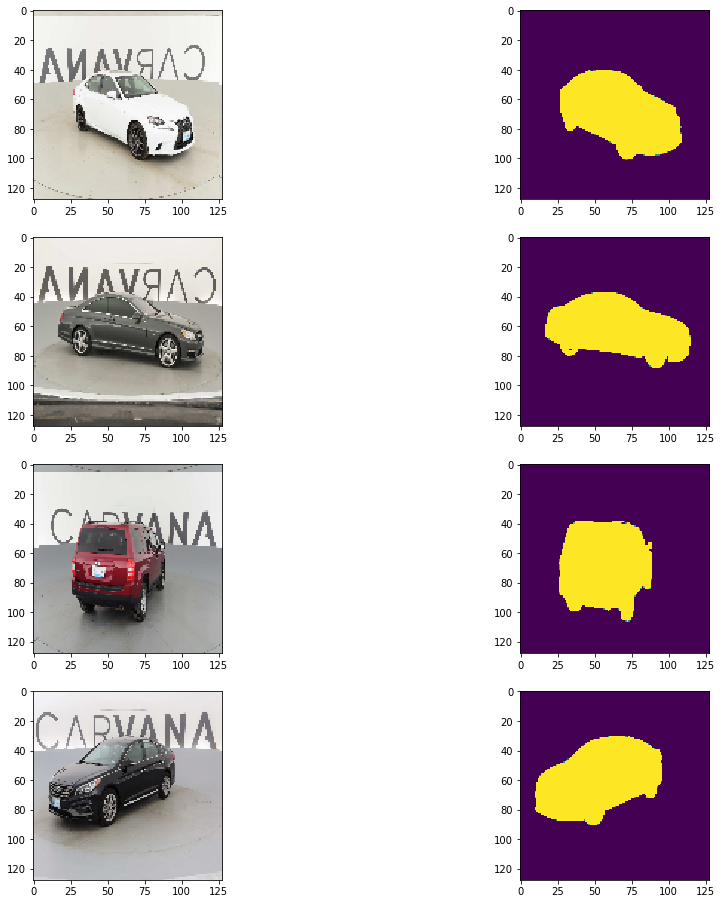

In [15]:
fig=plt.figure(figsize=(16, 16))
for i in [1, 2, 3, 4]:
    img, msk = next(train_gen)
    plt.subplot(4, 2, i*2-1)
    plt.imshow(img[0])
    plt.subplot(4, 2, i*2)
    plt.imshow(msk[0].reshape(128, 128))
    

In [0]:
from tensorflow.keras.models import load_model

MODEL_PATH = "carvana_model.h5"

def get_UNet(path):
  return load_model(path)

model.save(MODEL_PATH)

In [0]:
model = get_UNet(MODEL_PATH)

In [0]:
model.compile(
    optimizer='adam', 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)

In [0]:
def test_gen_small(data_dir, df_data, precess_batch_size, original_image_shape):
    while True:
        for k, ix in df_data.groupby(np.arange(len(df_data))//precess_batch_size):
            imgs = []
            labels = []
            for index, row in ix.iterrows():
                # images
                original_img = io.imread(data_dir + row.img)
                resized_img = transform.resize(original_img, original_image_shape)
                imgs.append(resized_img)

            imgs = np.array(imgs)
            yield imgs
test_gen = test_gen_small("input/test/", testdata, batch_size, input_shape)

steps = np.ceil(float(len(testdata)) / float(batch_size)).astype(int)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  if __name__ == '__main__':


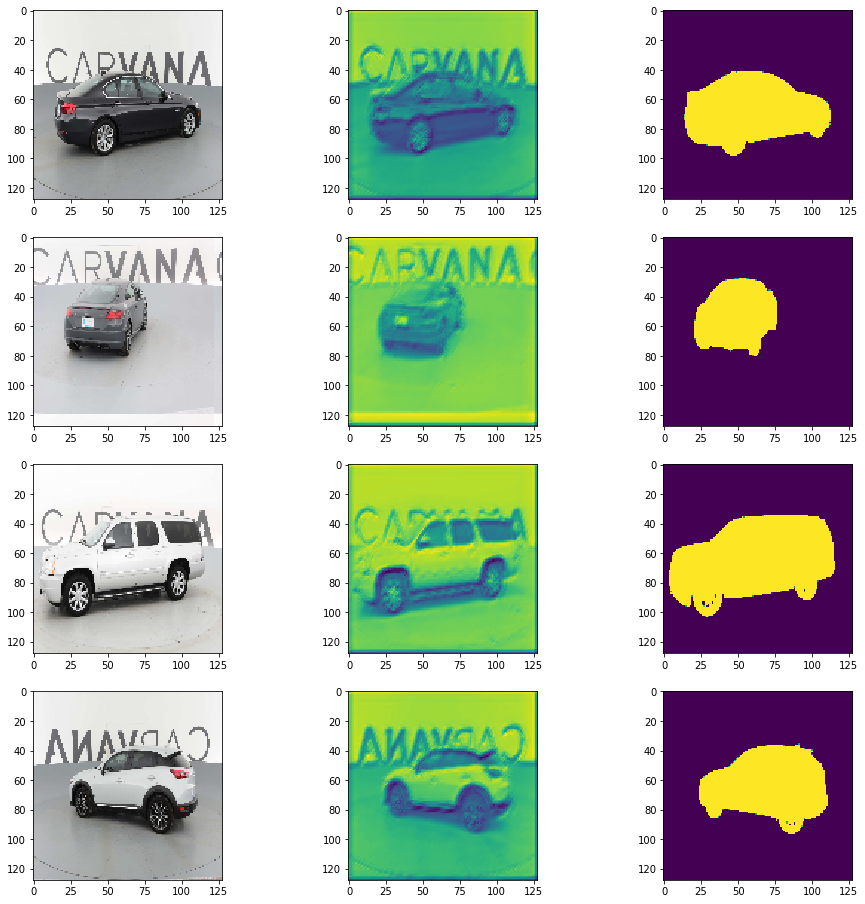

In [44]:
y_predicted = model.predict_generator(
    test_gen, 
    steps=1
)

fig=plt.figure(figsize=(16, 16))
for i in [1, 2, 3, 4]:
    img, msk = next(train_gen)
    pred = model.predict(img)
    plt.subplot(4, 3, i*3-2)
    plt.imshow(img[0])
    plt.subplot(4, 3, i*3-1)
    plt.imshow(pred[0].reshape(128,128))
    plt.subplot(4, 3, i*3)
    plt.imshow(msk[0].reshape(128, 128))
    

In [45]:
steps_per_epoch=np.ceil(float(len(train_masks)) / float(batch_size)).astype(int)
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=steps_per_epoch,
    epochs=50
)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  if __name__ == '__main__':


Epoch 1/50
100/100 [==============================] - 196s 2s/step - loss: 0.8745 - acc: 0.9628
Epoch 2/50
100/100 [==============================] - 201s 2s/step - loss: 0.3095 - acc: 0.9867
Epoch 3/50
100/100 [==============================] - 200s 2s/step - loss: 0.3086 - acc: 0.9870
Epoch 4/50
100/100 [==============================] - 198s 2s/step - loss: 0.2122 - acc: 0.9908
Epoch 5/50
100/100 [==============================] - 199s 2s/step - loss: 0.1847 - acc: 0.9920
Epoch 6/50
100/100 [==============================] - 197s 2s/step - loss: 0.1654 - acc: 0.9927
Epoch 7/50
100/100 [==============================] - 201s 2s/step - loss: 0.1505 - acc: 0.9933
Epoch 8/50
100/100 [==============================] - 200s 2s/step - loss: 0.1425 - acc: 0.9936
Epoch 9/50
100/100 [==============================] - 200s 2s/step - loss: 0.1334 - acc: 0.9940
Epoch 10/50
100/100 [==============================] - 199s 2s/step - loss: 0.1312 - acc: 0.9940
Epoch 11/50
100/100 [==================

In [65]:
tr_gen = data_gen_small("input/train/", "input/train_masks/", train_masks, batch_size, input_shape, mask_shape)
y_predicted = model.predict_generator(
  tr_gen, 
  steps=steps
)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  if __name__ == '__main__':


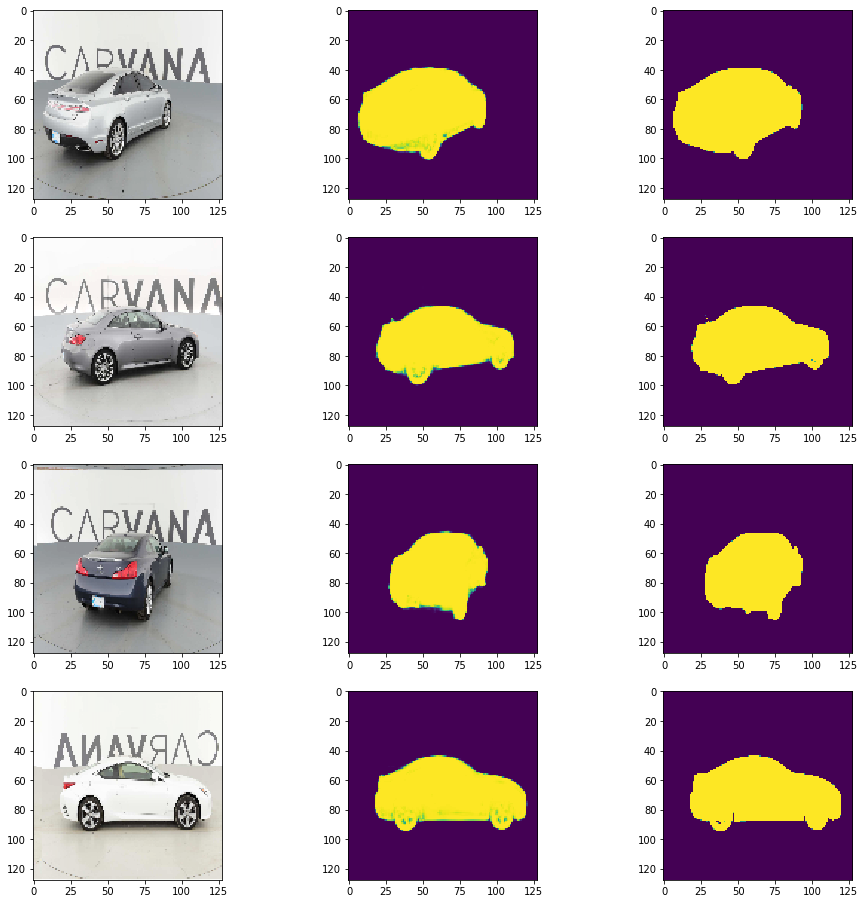

In [67]:
fig=plt.figure(figsize=(16, 16))
for i in [1, 2, 3, 4]:
    img, msk = next(tr_gen)
    pred = model.predict(img)
    plt.subplot(4, 3, i*3-2)
    plt.imshow(img[0])
    plt.subplot(4, 3, i*3-1)
    plt.imshow(pred[0].reshape(128,128))
    plt.subplot(4, 3, i*3)
    plt.imshow(msk[0].reshape(128, 128))